# DeepEnsemble
Technically this is combining the ensemble idea with aleatoric error via a Gaussian NLL loss. I think some call the Gaussian NLL loss approach (where you return the $\mu$ and $\sigma$ of a distribution of the output RV) mean-variance estimation (MVE). 

## The dataset: simple linefit

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [3]:
## first, import all the necessary modules
import arviz as az
import corner
import graphviz
import jax
from jax import random
import jax.numpy as jnp # yes i know this is confusing
import matplotlib.pyplot as plt
import numpy as np

## in numpyro, you must specify number of sampling chains you will use upfront

# words of wisdom from Tian Li and crew:
# on gpu, don't use conda, use pip install
# HMC after SBI to look at degeneracies between params
# different guides (some are slower but better at showing degeneracies)

import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [4]:
import sys
sys.path.append('..')
from src.scripts import train, models, analysis

In [11]:
loss_type = 'var_loss'
norm = 'False'
# options are 'no_var_loss' or 'var_loss'
# var_loss is a gaussian negative log likelihood option that incorporates a variance term (for aleatoric uncertainty)

## Generate line data
Unlike in the case of inference, here we need to upfront generate a dataframe and replicate a bunch of columns. We will generate using random draws from distributions that are similar to the priors in the case of the likelihood-based inference analysis.

In [14]:
# same simulator as in likelihood-based inference,
# but here we have 
def simulator(thetas):
    m, b = thetas
    x_data = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    sigma = 10
    ε = rs.normal(loc=0, scale=sigma, size = len(x_data)) 
    return m * x_data + b + ε

def simulator_no_noise(thetas):
    m, b = thetas
    x_data = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    return m * x_data + b

In [15]:
x_data = np.linspace(0, 100, 101)

length_df = 1000
#ms = np.zeros((length_df, 101))
ms_list = []#np.zeros((length_df, 1))
bs_list = []#np.zeros((length_df, 1))
ys_list = []
#true_sigmas = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    m = rs.uniform(low=0, high=10)
    b = rs.uniform(low=-10, high=10)    
    ms_list.append(m)
    bs_list.append(b)
    '''
    xs[r,:] = thetas_1d[0]#np.linspace(0, 100, 101)
    ms[r,:] = thetas_1d[1]#np.repeat(thetas_1d[0], 101)
    bs[r,:] = thetas_1d[2]#np.repeat(thetas_1d[1], 101)
    sigmas[r,:] = thetas_1d[3]#np.repeat(thetas_1d[2], 101)
    '''
    ys_list.append(simulator([m,b]))
ms_array = np.repeat(ms_list, len(x_data))
bs_array = np.repeat(bs_list, len(x_data))
xs_array = np.tile(x_data, length_df)
ys_array = np.reshape(ys_list, (length_df * len(x_data)))

<Figure size 640x480 with 0 Axes>

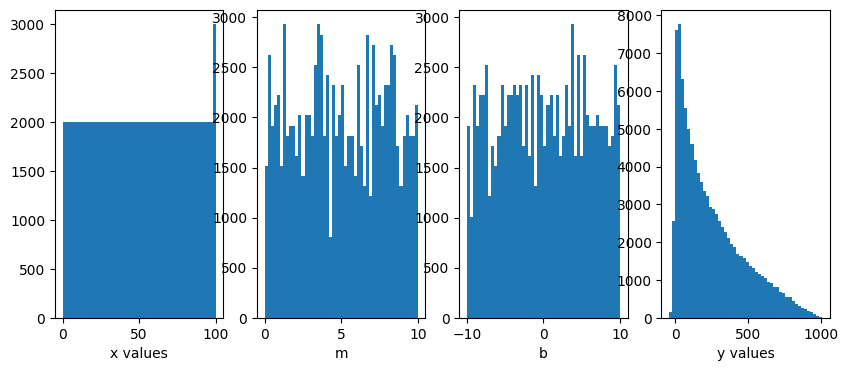

In [16]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(xs_array, bins=50)
ax0.set_xlabel('x values')
ax1 = fig.add_subplot(142)
ax1.hist(ms_array, bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(bs_array, bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(ys_array, bins=50)
ax3.set_xlabel('y values')
plt.show()

In [17]:
# combine all of the inputs into one array
# this will be fed into the neural network
inputs = np.array([xs_array, ms_array, bs_array]).T
print(np.shape(inputs))

(101000, 3)


In [18]:
if norm == 'True':
    # normalize everything before it goes into a network
    inputmin = np.min(inputs, axis = 0)
    inputmax = np.max(inputs, axis = 0)#, axis = 0)
    outputmin = np.min(ys_array)
    outputmax = np.max(ys_array)
    print('input min, max', inputmin, inputmax, 'output min, max', outputmin, outputmax)
    
    model_inputs = (inputs - inputmin) / (inputmax - inputmin)
    model_outputs = (ys_array - outputmin) / (outputmax - outputmin)
else:
    model_inputs = inputs
    model_outputs = ys_array

<Figure size 640x480 with 0 Axes>

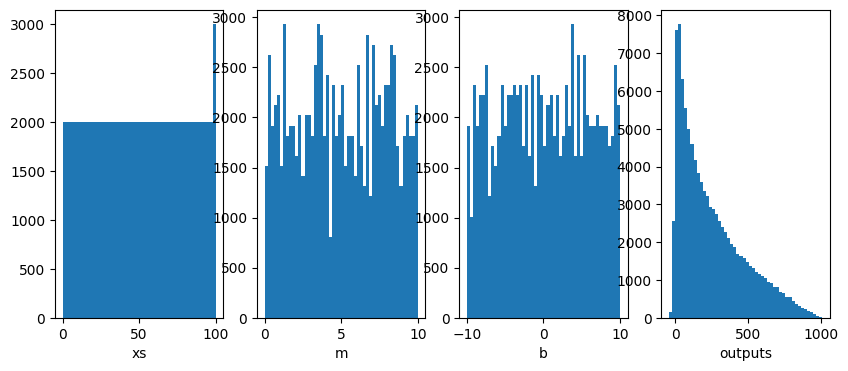

In [20]:
# now plot the histograms of the noramlized values
# to verify it worked
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(model_inputs[:,0], bins=50)
ax0.set_xlabel('xs')
ax1 = fig.add_subplot(142)
ax1.hist(model_inputs[:,1], bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(model_inputs[:,2], bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(model_outputs[:], bins=50)
ax3.set_xlabel('outputs')
plt.show()

In [97]:
# if they are now normalized (0 - 1) they should have the same distribution as before

(90900, 3) (90900,)
(3,)


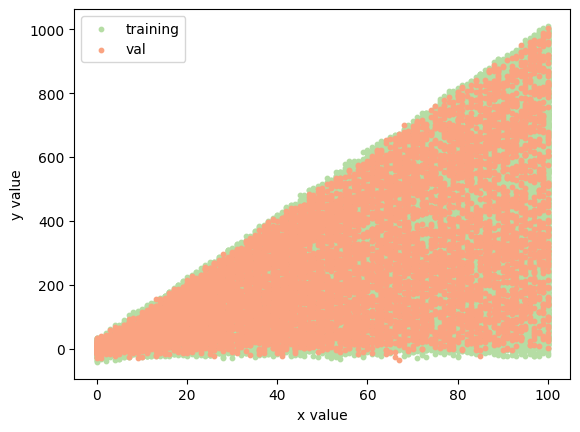

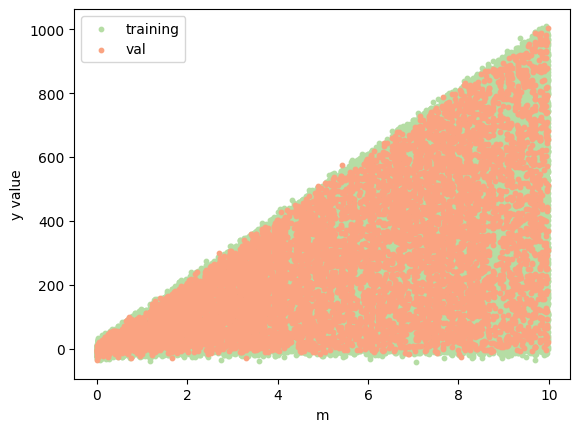

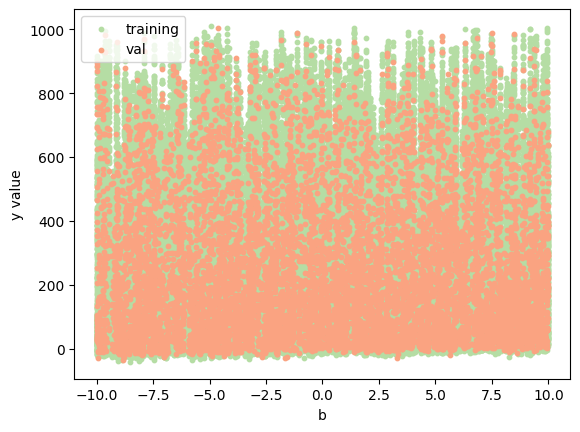

In [21]:
# prepare the training, validation, and test set split:
val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(model_inputs, model_outputs, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('m')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('b')
plt.ylabel('y value')
plt.show()

In [22]:
# okay now train the thing
BATCH_SIZE = 128

# add a dimension so that xs have a one channel input
#x_train = x_train.reshape(x_train.shape[0], 1) # 1 was the middle dimension
#x_val = x_val.reshape(x_val.shape[0], 1)

'''
print('y', np.shape(y_train))
print('x', np.shape(x_train))
STOP
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[1])
'''

trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (90900, 3)


In [23]:
# initialize the simple model
INIT_LR = 0.001
print("[INFO] initializing the gal model...")
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if loss_type == 'no_var_loss':
    model = models.de_no_var().to(device)
    # initialize our optimizer and loss function
    opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    lossFn = torch.nn.MSELoss(reduction="mean")
else:
    model = models.de_var().to(device)
    # initialize our optimizer and loss function
    opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    lossFn = torch.nn.GaussianNLLLoss(full=False, eps=1e-06, reduction="mean")#was full=False, default eps=1e-06
    # 1e-09 worked for one of the networks in the ensemble
#nn.MSELoss(reduction = "mean")

[INFO] initializing the gal model...


In [24]:
print(model)

de_var(
  (ln_1): Linear(in_features=3, out_features=100, bias=True)
  (act1): ReLU()
  (drop1): Dropout(p=0.1, inplace=False)
  (ln_2): Linear(in_features=100, out_features=100, bias=True)
  (act2): ReLU()
  (drop2): Dropout(p=0.1, inplace=False)
  (ln_3): Linear(in_features=100, out_features=100, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.1, inplace=False)
  (ln_4): Linear(in_features=100, out_features=2, bias=True)
)


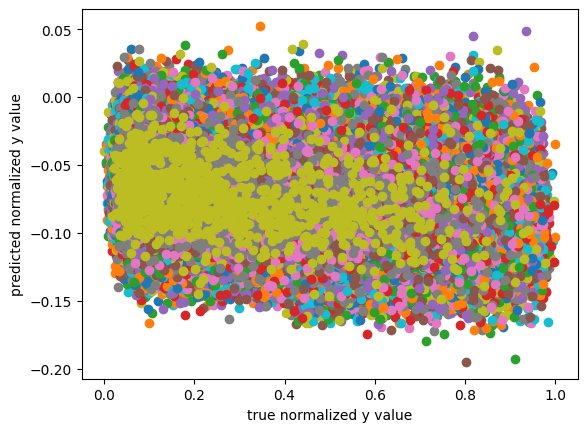

In [102]:
# plot what we're trying to predict
counter = 0
for (x, y) in trainDataLoader: # loading it up in batches
    #print('batch', counter, 'length', len(y))
    # send the input to the device
    (x, y) = (x.to(device), y.to(device))
    pred_tensor = model(x)
    pred = pred_tensor.detach().numpy()
    #print(y.shape, pred.shape)
    
    if loss_type == 'no_var_loss':
        plt.scatter(y, pred, linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor, y)
        #print('loss', loss.item())
    else:
        plt.errorbar(y, pred[:,0], yerr = abs(pred[:,1]), linestyle='None')
        plt.scatter(y, pred[:,0], linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor[:,0], y, pred_tensor[:,1]**2)
        #print('loss', loss.item())
    
    counter += 1
plt.xlabel('true normalized y value')
plt.ylabel('predicted normalized y value')
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.show()
# Interesting, before the model is trained it basically predicts the mean?

[INFO] training the network...
saving checkpoints?
False
starting here 0
epoch 0 0.0


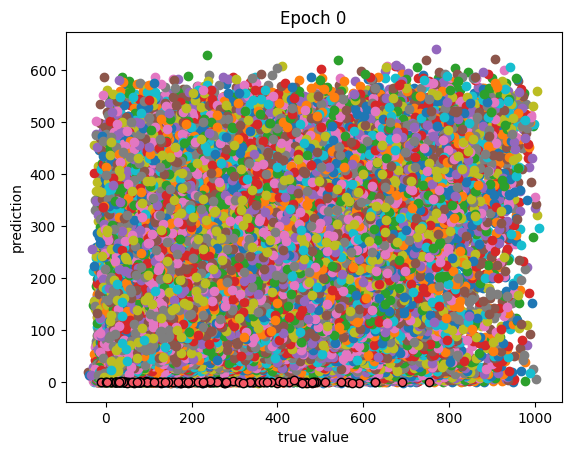

new best mse 5.148193836212158 in epoch 0
epoch 1 0.01
new best mse 4.613090515136719 in epoch 1
epoch 2 0.02
new best mse 4.289876461029053 in epoch 2
epoch 3 0.03
new best mse 4.034704685211182 in epoch 3
epoch 4 0.04
epoch 5 0.05


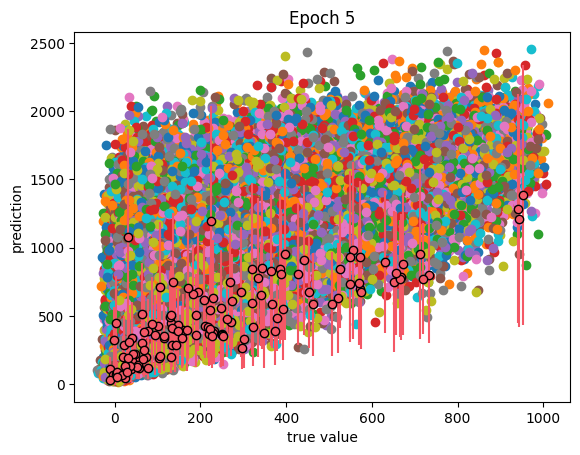

epoch 6 0.06
epoch 7 0.07
epoch 8 0.08
epoch 9 0.09
epoch 10 0.1


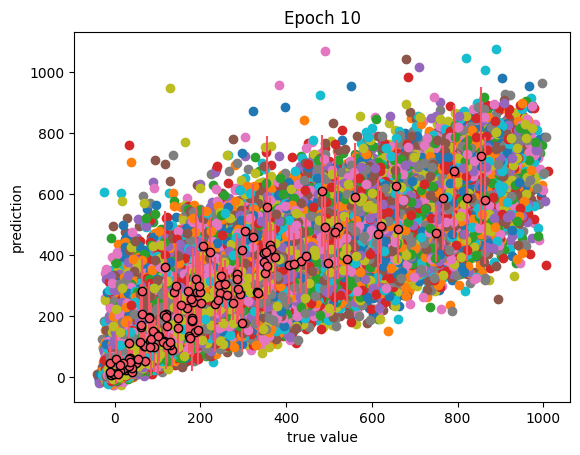

epoch 11 0.11
epoch 12 0.12
epoch 13 0.13
epoch 14 0.14
epoch 15 0.15


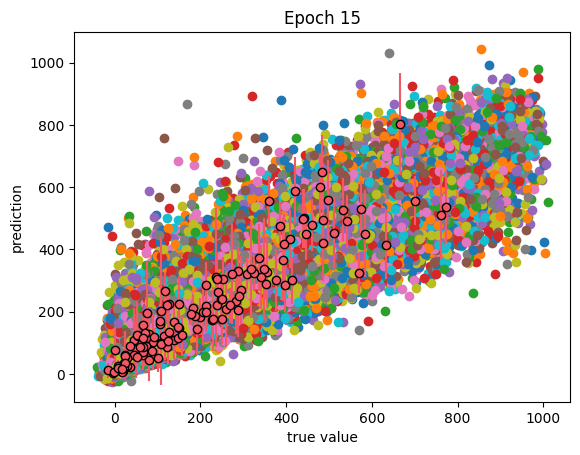

epoch 16 0.16
epoch 17 0.17
epoch 18 0.18
epoch 19 0.19
epoch 20 0.2


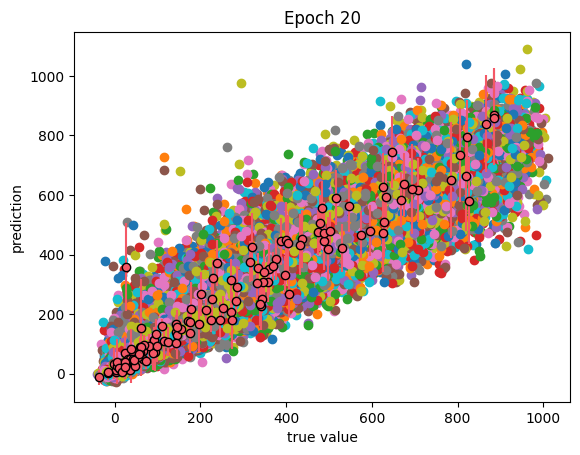

epoch 21 0.21
epoch 22 0.22
epoch 23 0.23
epoch 24 0.24
epoch 25 0.25


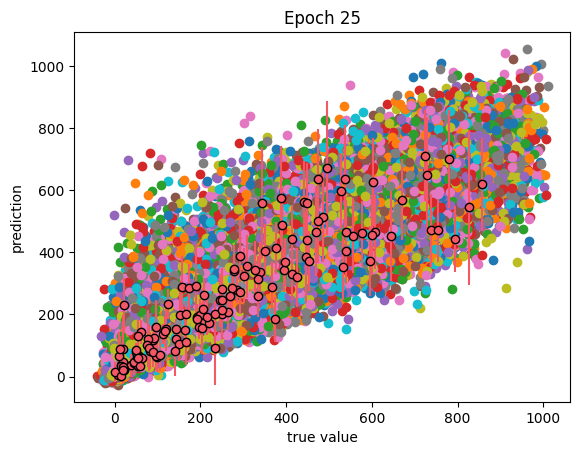

epoch 26 0.26
epoch 27 0.27
epoch 28 0.28
epoch 29 0.29
epoch 30 0.3


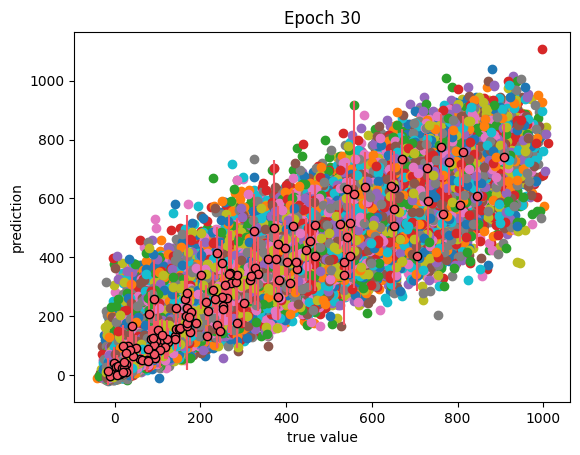

epoch 31 0.31
epoch 32 0.32
epoch 33 0.33
epoch 34 0.34
epoch 35 0.35


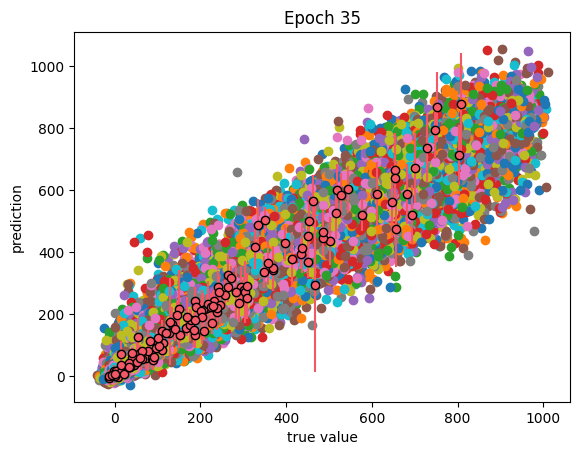

epoch 36 0.36
epoch 37 0.37
epoch 38 0.38
epoch 39 0.39
epoch 40 0.4


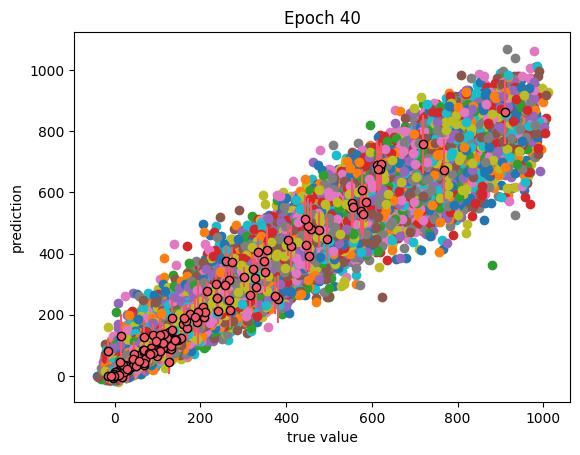

epoch 41 0.41
epoch 42 0.42
epoch 43 0.43
epoch 44 0.44
epoch 45 0.45


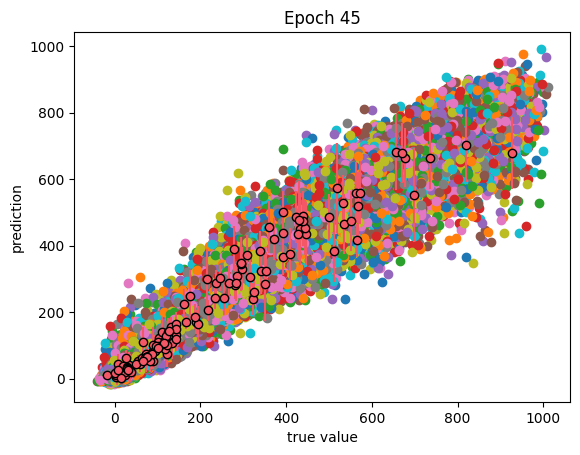

epoch 46 0.46
epoch 47 0.47
epoch 48 0.48
epoch 49 0.49
epoch 50 0.5


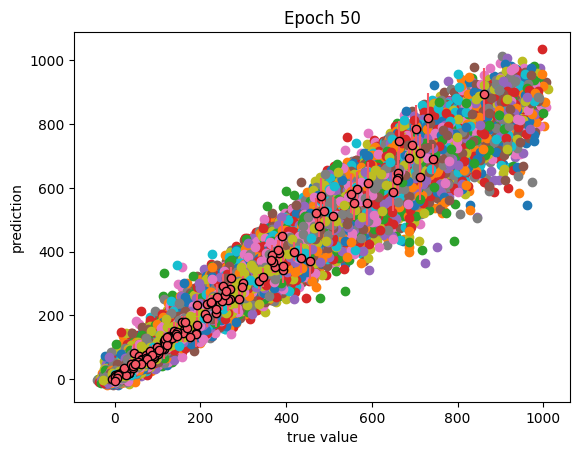

epoch 51 0.51
epoch 52 0.52
epoch 53 0.53
epoch 54 0.54
epoch 55 0.55


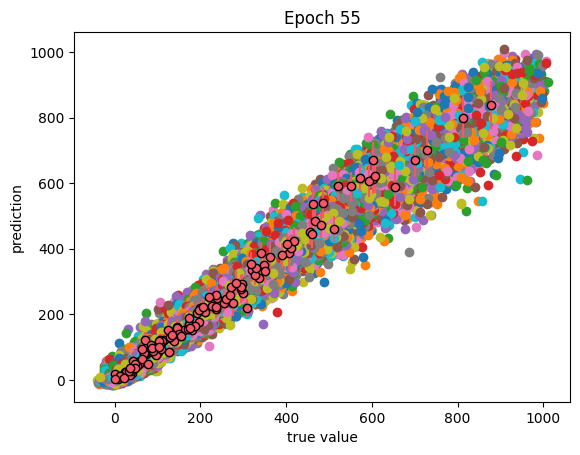

epoch 56 0.56
epoch 57 0.57
epoch 58 0.58
epoch 59 0.59
epoch 60 0.6


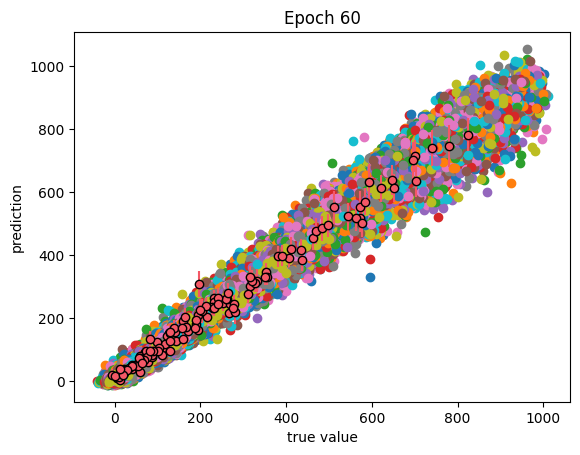

epoch 61 0.61
epoch 62 0.62
epoch 63 0.63
epoch 64 0.64
epoch 65 0.65


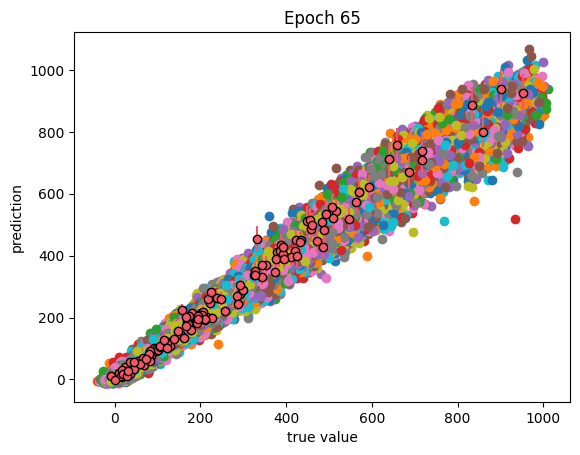

epoch 66 0.66
epoch 67 0.67
epoch 68 0.68
epoch 69 0.69
epoch 70 0.7


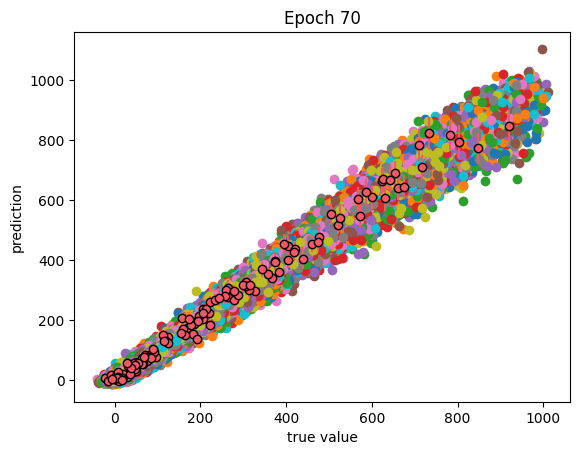

epoch 71 0.71
epoch 72 0.72
epoch 73 0.73
epoch 74 0.74
epoch 75 0.75


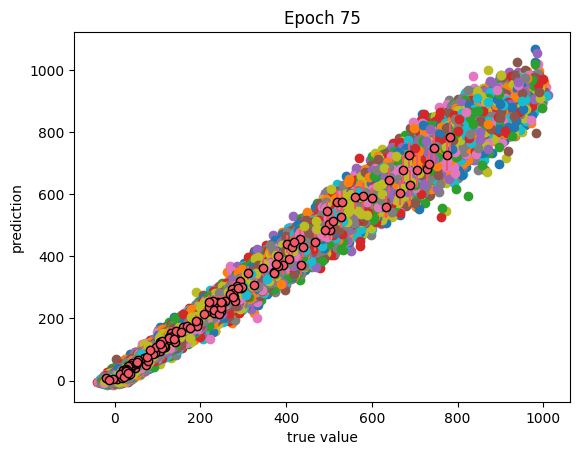

epoch 76 0.76
epoch 77 0.77
epoch 78 0.78
epoch 79 0.79
epoch 80 0.8


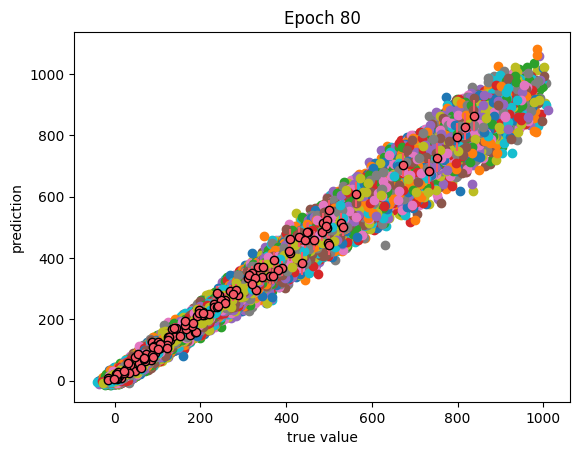

epoch 81 0.81
epoch 82 0.82
epoch 83 0.83
epoch 84 0.84
epoch 85 0.85


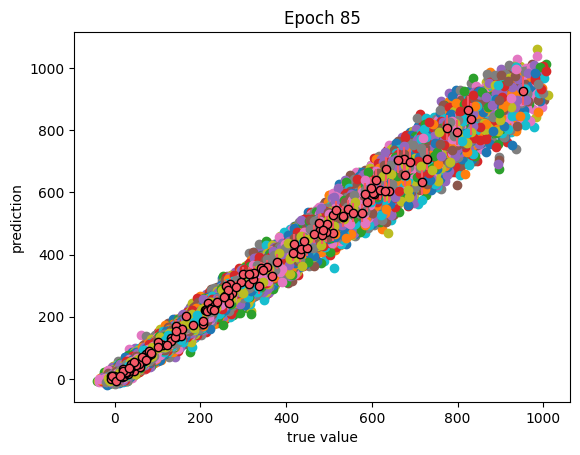

epoch 86 0.86
epoch 87 0.87
epoch 88 0.88
epoch 89 0.89
epoch 90 0.9


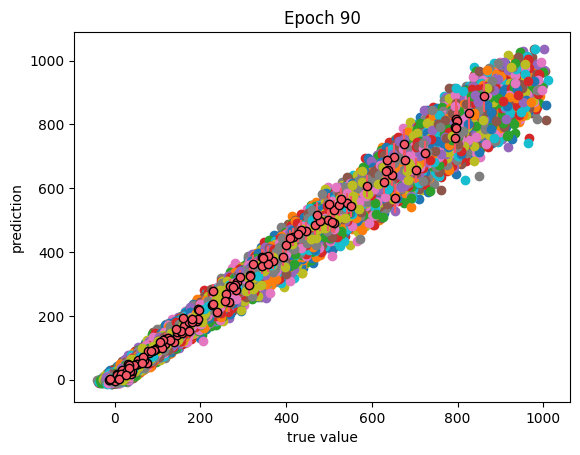

epoch 91 0.91
epoch 92 0.92
epoch 93 0.93
epoch 94 0.94
epoch 95 0.95


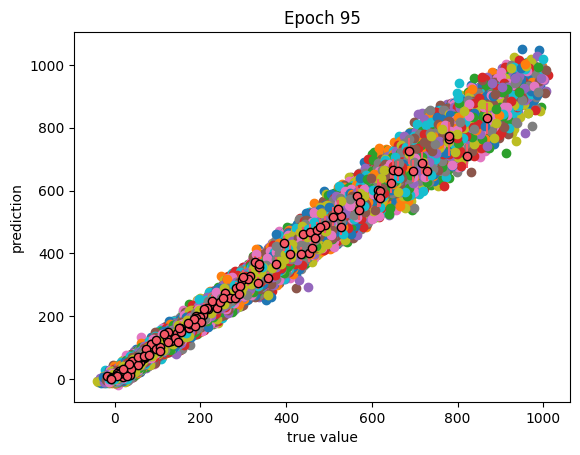

epoch 96 0.96
epoch 97 0.97
epoch 98 0.98
epoch 99 0.99
epoch 0 0.0


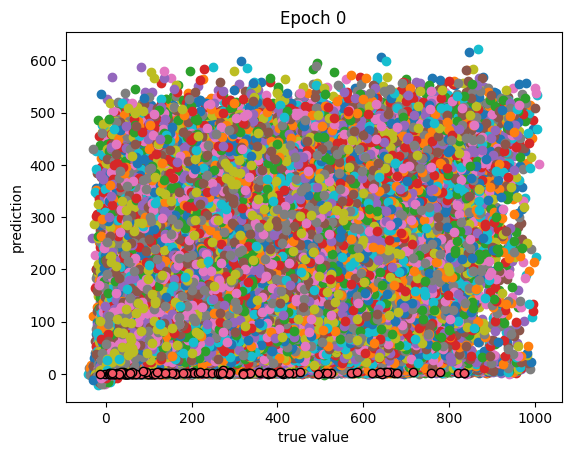

epoch 1 0.01
epoch 2 0.02
epoch 3 0.03
epoch 4 0.04
epoch 5 0.05


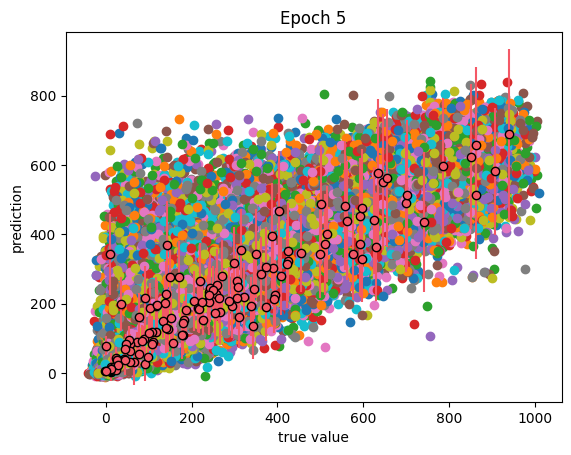

epoch 6 0.06
epoch 7 0.07
epoch 8 0.08
epoch 9 0.09
epoch 10 0.1


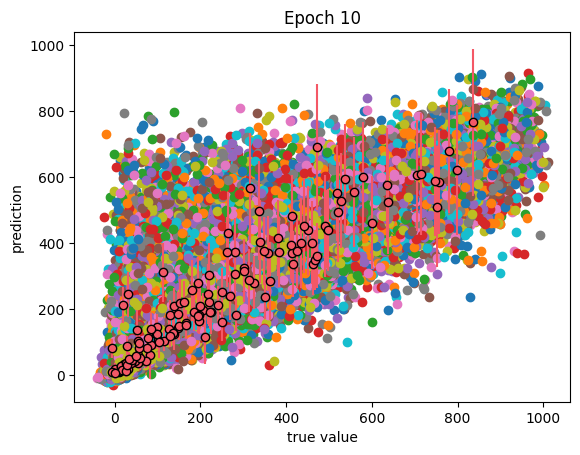

epoch 11 0.11
new best mse 4.029115676879883 in epoch 11
epoch 12 0.12
new best mse 3.9329288005828857 in epoch 12
epoch 13 0.13
new best mse 3.9006636142730713 in epoch 13
epoch 14 0.14
new best mse 3.880140781402588 in epoch 14
epoch 15 0.15


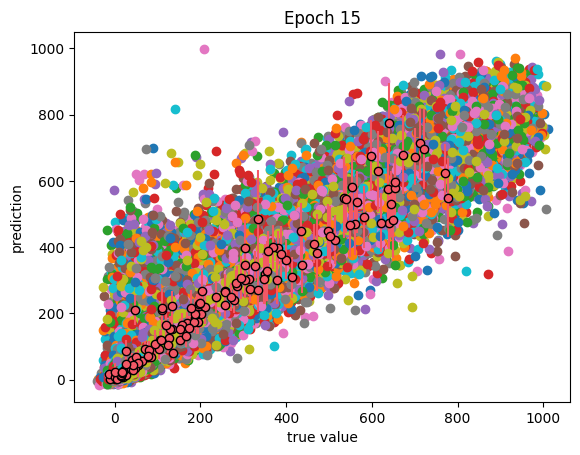

new best mse 3.8561549186706543 in epoch 15
epoch 16 0.16
new best mse 3.851663827896118 in epoch 16
epoch 17 0.17
new best mse 3.8049306869506836 in epoch 17
epoch 18 0.18
epoch 19 0.19
epoch 20 0.2


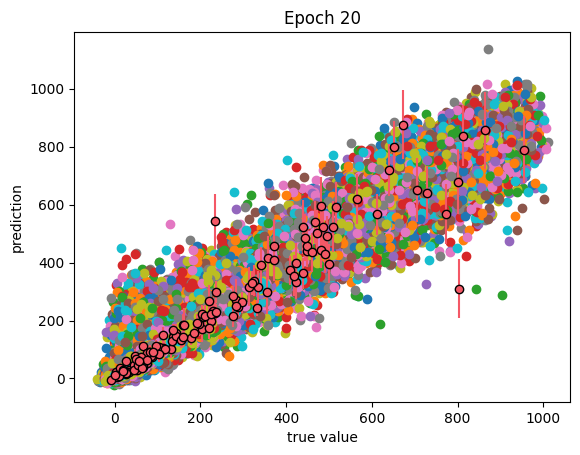

epoch 21 0.21
epoch 22 0.22
epoch 23 0.23
epoch 24 0.24
epoch 25 0.25


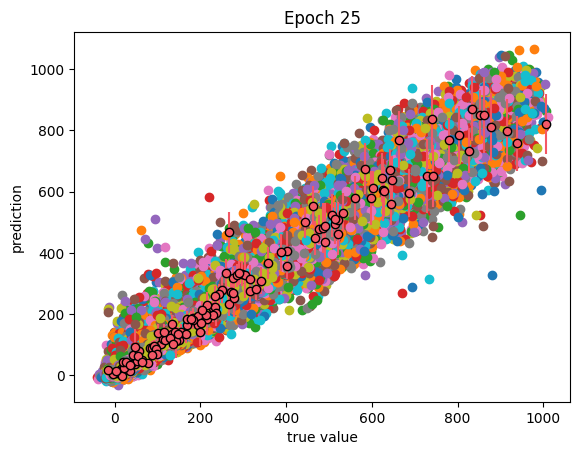

epoch 26 0.26
epoch 27 0.27
new best mse 3.7903804779052734 in epoch 27
epoch 28 0.28
epoch 29 0.29
epoch 30 0.3


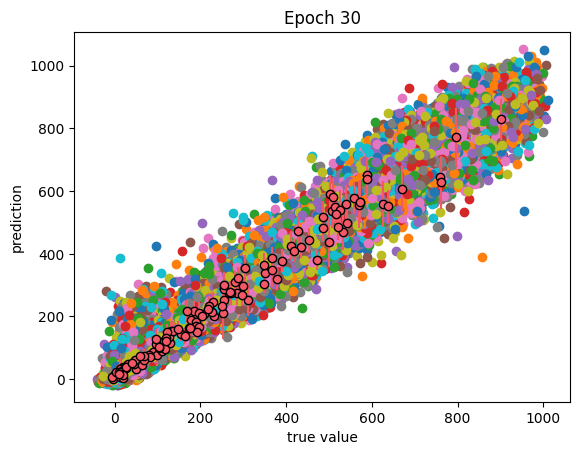

epoch 31 0.31
epoch 32 0.32
epoch 33 0.33
epoch 34 0.34
epoch 35 0.35


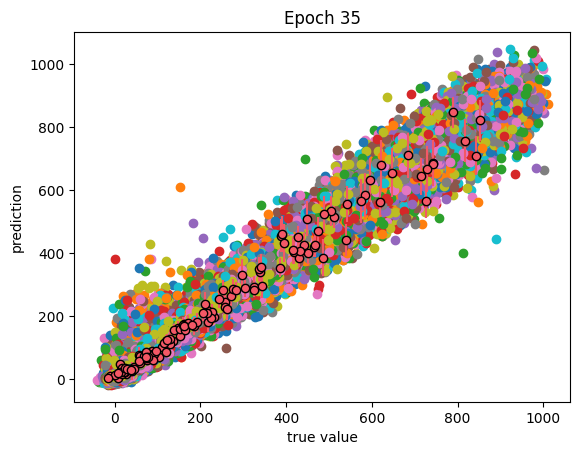

epoch 36 0.36
epoch 37 0.37
epoch 38 0.38
epoch 39 0.39
epoch 40 0.4


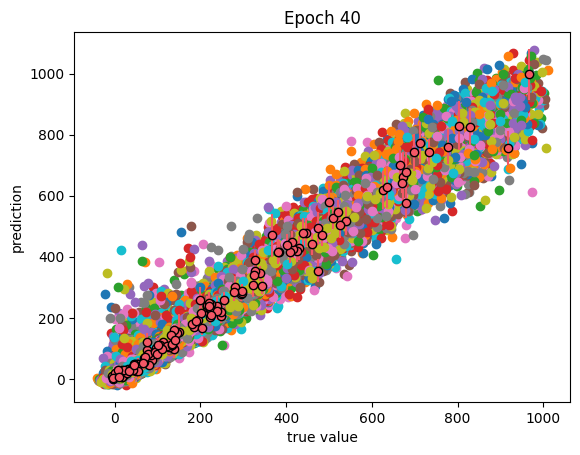

epoch 41 0.41
epoch 42 0.42
epoch 43 0.43
epoch 44 0.44
epoch 45 0.45


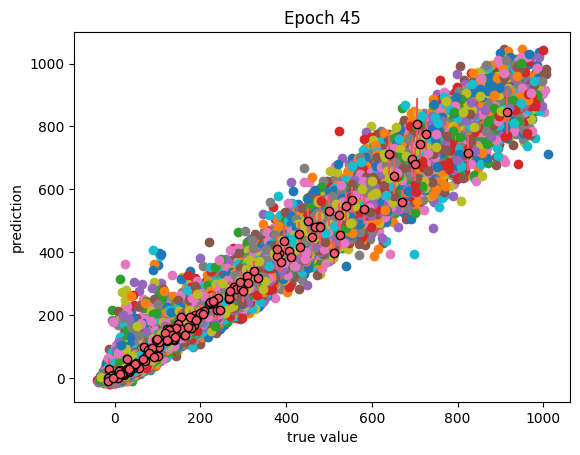

epoch 46 0.46
epoch 47 0.47
epoch 48 0.48
epoch 49 0.49
epoch 50 0.5


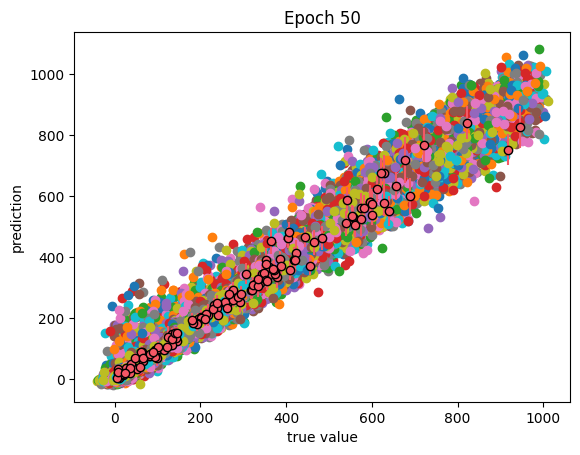

epoch 51 0.51
epoch 52 0.52
epoch 53 0.53
epoch 54 0.54
epoch 55 0.55


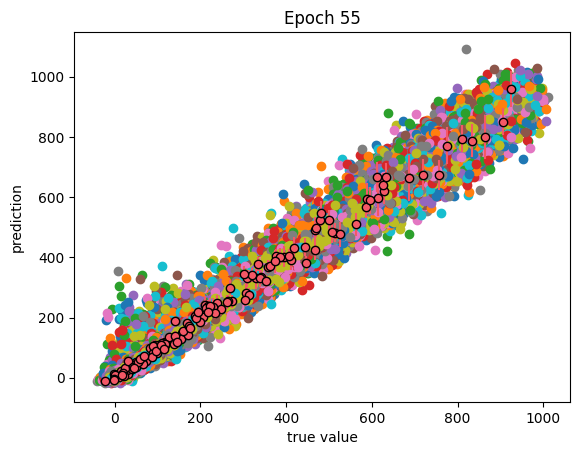

epoch 56 0.56
epoch 57 0.57
epoch 58 0.58
epoch 59 0.59
epoch 60 0.6


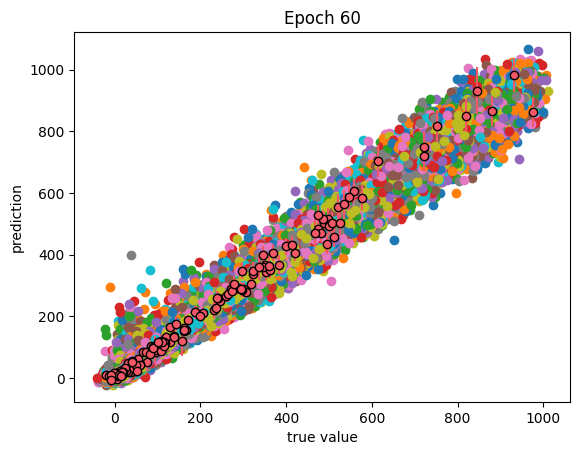

epoch 61 0.61
epoch 62 0.62
epoch 63 0.63
epoch 64 0.64
epoch 65 0.65


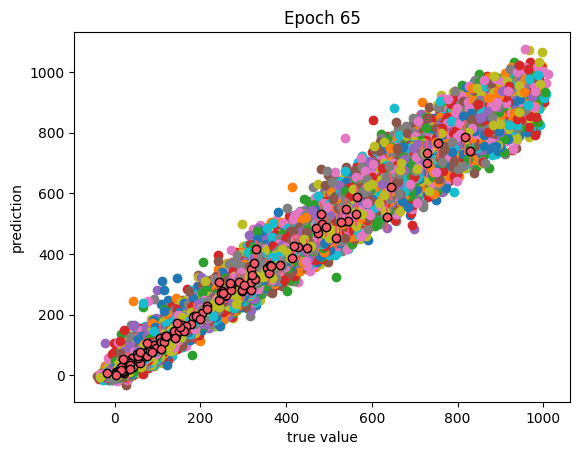

epoch 66 0.66
epoch 67 0.67
epoch 68 0.68
epoch 69 0.69
epoch 70 0.7


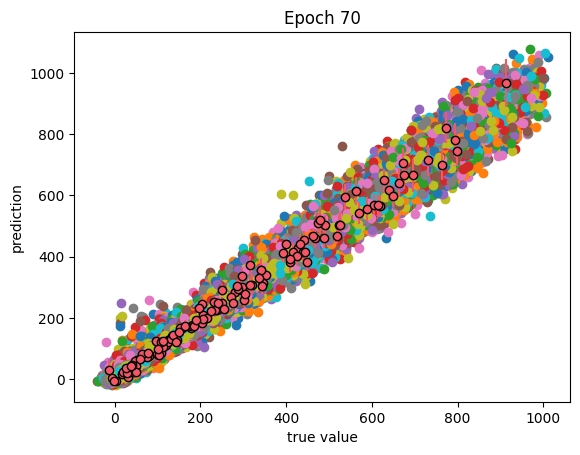

epoch 71 0.71
epoch 72 0.72
epoch 73 0.73
epoch 74 0.74
epoch 75 0.75


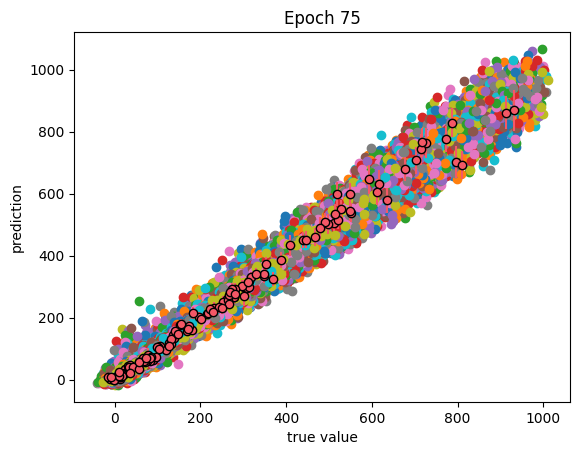

epoch 76 0.76
epoch 77 0.77
epoch 78 0.78
epoch 79 0.79
epoch 80 0.8


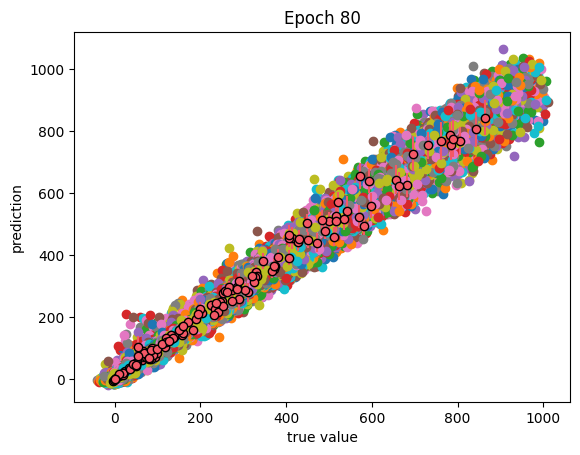

epoch 81 0.81
epoch 82 0.82
epoch 83 0.83
epoch 84 0.84
epoch 85 0.85


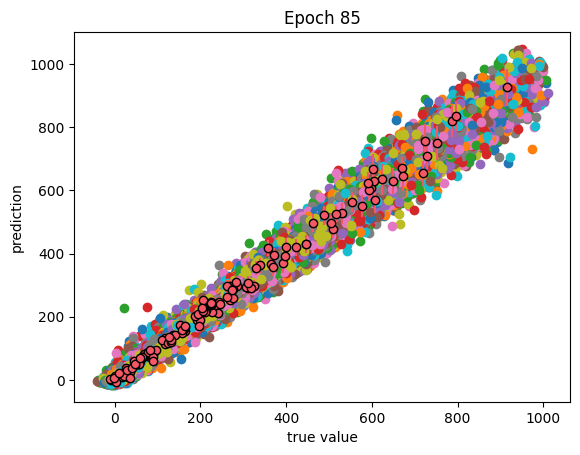

epoch 86 0.86
epoch 87 0.87
epoch 88 0.88
epoch 89 0.89
epoch 90 0.9


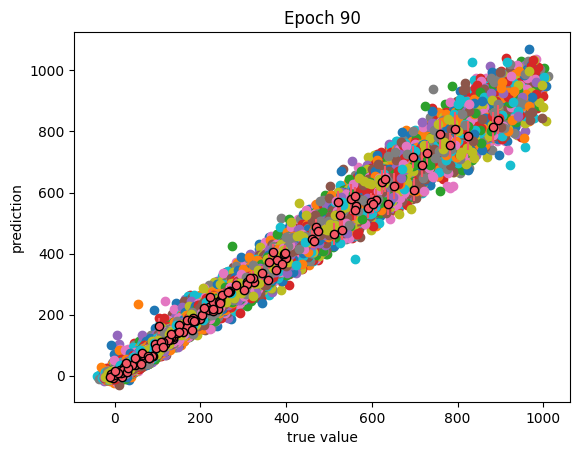

epoch 91 0.91
epoch 92 0.92
epoch 93 0.93
epoch 94 0.94
epoch 95 0.95


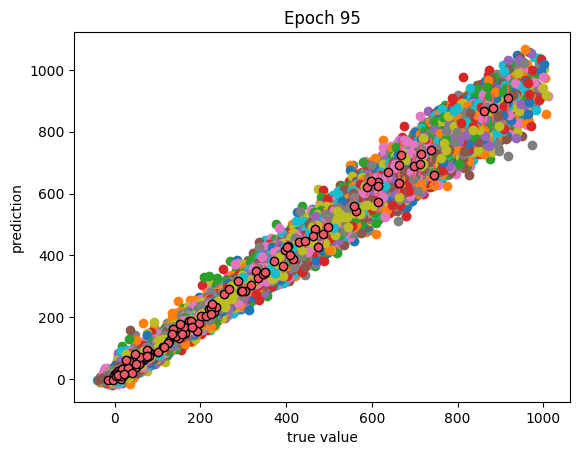

epoch 96 0.96
epoch 97 0.97
epoch 98 0.98
epoch 99 0.99
start at 1704329776.090963 end at 1704330029.184672
253.09370923042297


<Figure size 640x480 with 0 Axes>

In [25]:
n_models = 2
model_ensemble = train.train_DE(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             device,
             loss_type,
             n_models,
             model_name='DE',
             EPOCHS=100,
             save_checkpoints=False,
             plot=True)
 

## Test the model
To run it through it's paces, draw and one set of (m, b) values and run it through just one of the above trained models from the ensemble. This will work even if you only train one.

In [33]:
m_true = np.repeat(1, len(x_data))
b_true = np.repeat(5, len(x_data))


thetas_1d_true = np.array([x_data, m_true, b_true]).T
y_true = simulator([m_true[0], b_true[0]])
y_true_no_noise = simulator_no_noise([m_true[0], b_true[0]])
# now use one of the NNs to make a prediction
model = model_ensemble[0]
model.eval()
# first, normalize the x value using the xmin and xmax before
'''
norm_inputs = (inputs - inputmin) / (inputmax - inputmin)
norm_outputs = (ys - outputmin) / (outputmax - outputmin)
'''

if norm == 'True':
    norm_thetas = (thetas_1d_true - inputmin) / (inputmax - inputmin)
    
    y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
    # now un-normalize this so you can plot it
    if loss_type == 'var_loss':
        y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
        y_pred_sigma = abs((y_norm_pred[:,1]) * (outputmax - outputmin) + outputmin)
    else:
        y_pred = (y_norm_pred) * (outputmax - outputmin) + outputmin
        y_pred_sigma = 0
else:
    y_notnorm_pred = model(torch.Tensor(thetas_1d_true)).detach().numpy()
    if loss_type == 'var_loss':
        y_pred = y_notnorm_pred[:,0]
        y_pred_sigma = abs(y_notnorm_pred[:,1])
    else:
        y_pred = y_notnorm_pred
        y_pred_sigma = 0
    
    

### Aleatoric Error
Aleatoric error can be calculated individually for each model. It is defined using the sigma output from each individual NN.


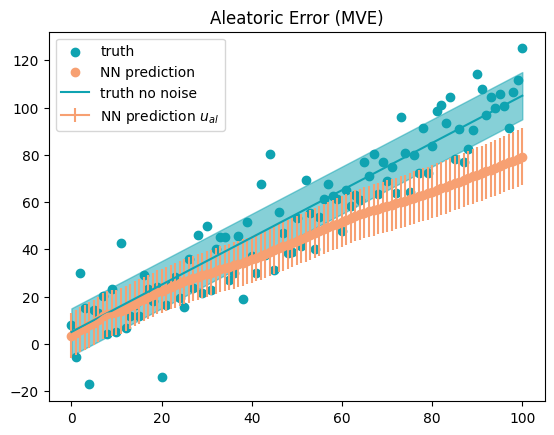

In [35]:
# plot
plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)
plt.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072')

if loss_type == 'var_loss':
    plt.errorbar(x_data, y_pred, yerr = y_pred_sigma, label = r'NN prediction $u_{al}$', color = '#F7A072')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
plt.title('Aleatoric Error (MVE)')
plt.show()


### Aleatoric error can also be defined from the combination of NNs
$\sigma_{al} = \sqrt{\frac{1}{N}\sum_{n=1}^N \sigma_i^2} = \sqrt{mean(\sigma_i^2)}$

It is the mean of the predicted $\sigma_i$ values from each network.

### Epistemic error is also defined from the ensemble
$\sigma_{ep} = \sqrt{\frac{1}{N}\sum_{n=1}^N\mu_i^2 - mean(\mu_i)^2} = stdev(\mu_i)$

It is the standard deviation of the predicted values $\mu_i$ from each network.

### Plot aleatoric and epistemic error for each model and for the ensemble

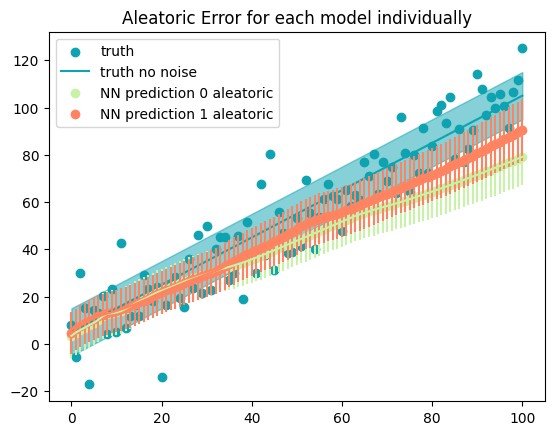

(2, 101) (2, 101)


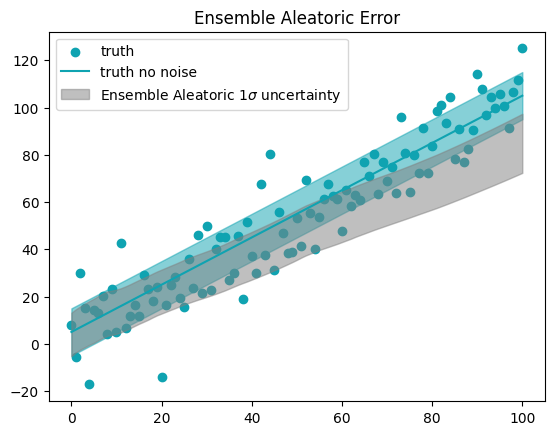

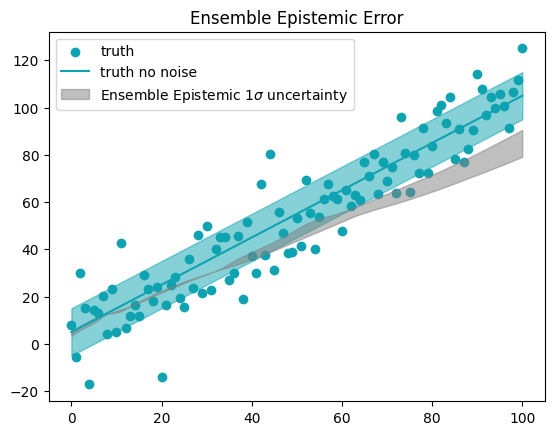

In [49]:
color_list = ['#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360']

# first plot the true values
plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)


y_pred_list = []
y_sigma_list = []

for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    if norm == 'True':
        y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
        # now un-normalize this so you can plot it
        if loss_type == 'var_loss':
            y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
            y_pred_sigma = abs((y_norm_pred[:,1]) * (outputmax - outputmin) + outputmin)
        else:
            y_pred = (y_norm_pred) * (outputmax - outputmin) + outputmin
            y_pred_sigma = 0
    else:
        y_notnorm_pred = model(torch.Tensor(thetas_1d_true)).detach().numpy()
        if loss_type == 'var_loss':
            y_pred = y_notnorm_pred[:,0]
            y_pred_sigma = abs(y_notnorm_pred[:,1])
        else:
            y_pred = y_notnorm_pred
            y_pred_sigma = 0
    plt.scatter(x_data, y_pred, label = f'NN prediction {m} aleatoric', color = color_list[m])
    if loss_type == 'var_loss':
        plt.errorbar(x_data, y_pred, yerr = y_pred_sigma, color = color_list[m])
    y_pred_list.append(np.reshape(y_pred, len(x_data)))
    y_sigma_list.append(np.reshape(y_pred_sigma, len(x_data)))
plt.title('Aleatoric Error for each model individually')
plt.legend()
plt.show()

print(np.shape(y_sigma_list), np.shape(y_pred_list))


ensemble_aleatoric_error = np.sqrt(np.mean(np.array(y_sigma_list)**2, axis = 0))
ensemble_epistemic_error = np.std(y_pred_list, axis = 0)

plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)

plt.fill_between(x_data,
                 np.mean(y_pred_list, axis = 0) - ensemble_aleatoric_error,
                 np.mean(y_pred_list, axis = 0) + ensemble_aleatoric_error,
                 color = 'grey', alpha = 0.5,
                 label = r'Ensemble Aleatoric 1$\sigma$ uncertainty')
plt.legend()
plt.title('Ensemble Aleatoric Error')
plt.show()

plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)

plt.fill_between(x_data,
                 np.mean(y_pred_list, axis = 0) - ensemble_epistemic_error,
                 np.mean(y_pred_list, axis = 0) + ensemble_epistemic_error,
                 color = 'grey', alpha = 0.5,
                 label = r'Ensemble Epistemic 1$\sigma$ uncertainty')
plt.legend()
plt.title('Ensemble Epistemic Error')
plt.show()
                 
                 
